In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Functions

In [2]:
from random import random
from tqdm import trange
import math
from scipy.stats import mannwhitneyu
from scipy.stats import chisquare
from scipy.stats import kstest

def generate_sim(n, RTP):
    sim = []

    for _ in range(n):
        x = math.floor(RTP * 100 / (1 - random()))/100
        x = max(x, 1)
        sim.append(x)
    sim = np.array(sim)
    return sim


def test(observ, RTP=0.96, display=False, verbose=False, n_bins=7):
    sim = generate_sim(observ.shape[0], RTP)
    if display:
        fig, axs = plt.subplots(figsize=(15, 5), ncols = 3)

        sns.histplot(1/sim, bins=50, alpha=0.3, label='simulator', stat='probability', ax=axs[0])
        sns.histplot(1/observ, bins=50, alpha=0.3, label='observed', stat='probability', ax=axs[0])
        axs[0].legend()
        axs[0].set_title("Density Histogram")


        sns.kdeplot(1/sim, alpha=0.3, label='simulator', ax=axs[1])
        sns.kdeplot(1/observ, alpha=0.3, label='observed', ax=axs[1])
        axs[1].legend()
        axs[1].set_title("Kernel Density Function");


        sns.histplot(1/sim, cumulative=True, label='simulator', bins=len(sim), stat="density",
                    element="step", alpha=0.3, fill=False, ax=axs[2])
        sns.histplot(1/observ, cumulative=True, label='observed', bins=len(sim), stat="density",
                    element="step", alpha=0.3, fill=False, ax=axs[2])
        axs[2].legend()
        axs[2].set_title("Cumulative distribution function")

    stat_mw, p_value_mw = mannwhitneyu(1/observ, 1/sim)
    if verbose:
        print(f"Mann–Whitney U Test: statistic={stat_mw:.4f}, p-value={p_value_mw:.4f}")

    _, bins = pd.qcut(np.concatenate((1/observ, 1/sim)), q=n_bins, retbins=True)
    bins[0] = 0
    stat_chi2, p_value_chi2 = chisquare(
        pd.cut(1/observ, bins=bins).value_counts().values,
        pd.cut(1/sim, bins=bins).value_counts().values,
    )
    if verbose:
        print(f"Chi-squared Test: statistic={stat_chi2:.4f}, p-value={p_value_chi2:.4f}")

    stat_ks, p_value_ks = kstest(1/observ, 1/sim)
    if verbose:
        print(f"Kolmogorov-Smirnov Test: statistic={stat_ks:.4f}, p-value={p_value_ks:.4f}")

    return p_value_mw, p_value_chi2, p_value_ks


def display_results(result):
    fig, axs = plt.subplots(figsize=(15, 5), ncols = 3)
    sns.boxplot(np.array(result)[:,0], ax=axs[0])
    axs[0].set_title(f"Mann–Whitney U Test, p_value: {np.quantile(np.array(result)[:,0], 0.25):0.2f} {np.quantile(np.array(result)[:,0], 0.75):0.2f}")
    sns.boxplot(np.array(result)[:,1], ax=axs[1])
    axs[1].set_title(f"Chi-Squared Test, p_value {np.quantile(np.array(result)[:,1], 0.25):0.2f} {np.quantile(np.array(result)[:,1], 0.75):0.2f}")
    sns.boxplot(np.array(result)[:,2], ax=axs[2])
    axs[2].set_title(f"Kolmogorov-Smirnov Test, p_value {np.quantile(np.array(result)[:,2], 0.25):0.2f} {np.quantile(np.array(result)[:,2], 0.75):0.2f}")

    res_df = pd.DataFrame(result, columns=['Mann–Whitney U Test', 'Chi-Squared Test', 'Kolmogorov-Smirnov Test'])
    display(res_df.quantile([0.25, 0.75]).T)    

# Aviator

## load data

In [3]:
data_df = []

for root, dirs, files in os.walk("."):
    for n, f in enumerate(files):
        if "xlsx" in f:
            df_ = pd.read_excel(f)
            df_['file'] = f
            df_['Coefficient'] = df_['Coefficient'].str.replace("x", "").astype('float')
            df_['inv_coef'] = 1/df_['Coefficient']
            data_df.append(df_)

## Evaluate RTP

$$\mathbf{P}(\xi = 0) = \mathbf{P}\left(\frac{RTP}{x} \le 1\right) + \mathbf{P}\left(1 < \frac{RTP}{x} < 1.01\right) =$$
$$= \mathbf{P}\left(\frac{RTP}{x} < 1.01\right) = \mathbf{P}\left(\frac{RTP}{1.01} < x\right) = 1 - \frac{RTP}{1.01}$$
$$RTP =  1.01\left(1 - \mathbf{P_{obs}}\left(\xi = 0\right)\right)$$

Text(0.5, 1.0, 'RTP Aviator boxplot')

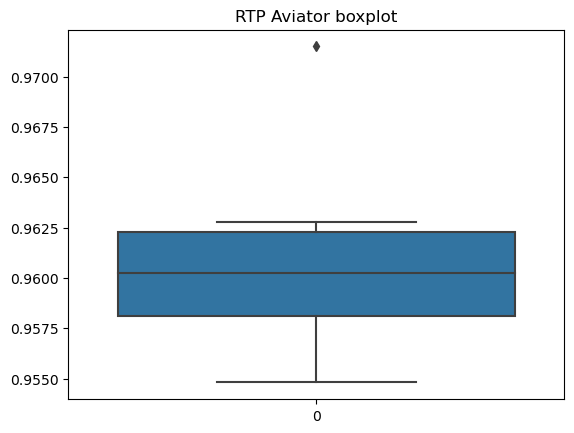

In [4]:
RTP_res = []
for  i in range(len(data_df)):
    b = 1.01 # floor
# b = 1.005 # round

    a = (data_df[i]['Coefficient'] == 1).mean()
    RTP = b * (1 - a)
    RTP_res.append(RTP)

sns.boxplot(RTP_res)
plt.title("RTP Aviator boxplot")

In [5]:
RTP_res

[0.9715022421524664,
 0.9597896749521989,
 0.954803451581975,
 0.9575620767494357,
 0.9627863603618027,
 0.9607426291287964]

## Simulating

Mann–Whitney U Test: statistic=77087219.0000, p-value=0.0955
Chi-squared Test: statistic=31.3555, p-value=0.0000
Kolmogorov-Smirnov Test: statistic=0.0134, p-value=0.2124


(0.09549624250453695, 2.1678813790183957e-05, 0.21242473273322782)

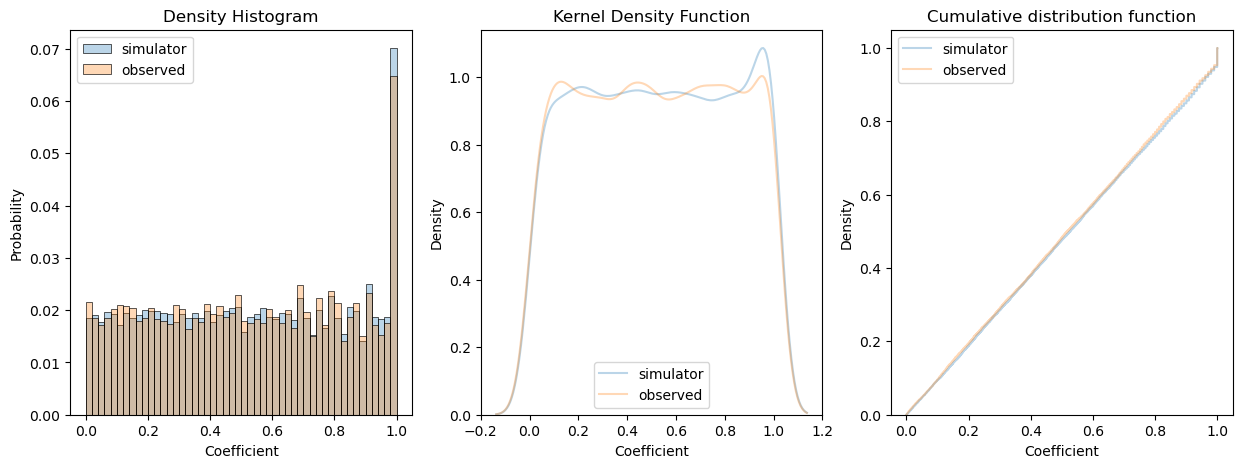

In [6]:
test(data_df[4]['Coefficient'], RTP=0.96, display=True, verbose=True)

100%|██████████| 100/100 [00:04<00:00, 20.90it/s]


,0.25,0.75
Mann–Whitney U Test,0.274420,0.708604
Chi-Squared Test,0.123943,0.469294
Kolmogorov-Smirnov Test,0.338048,0.833813


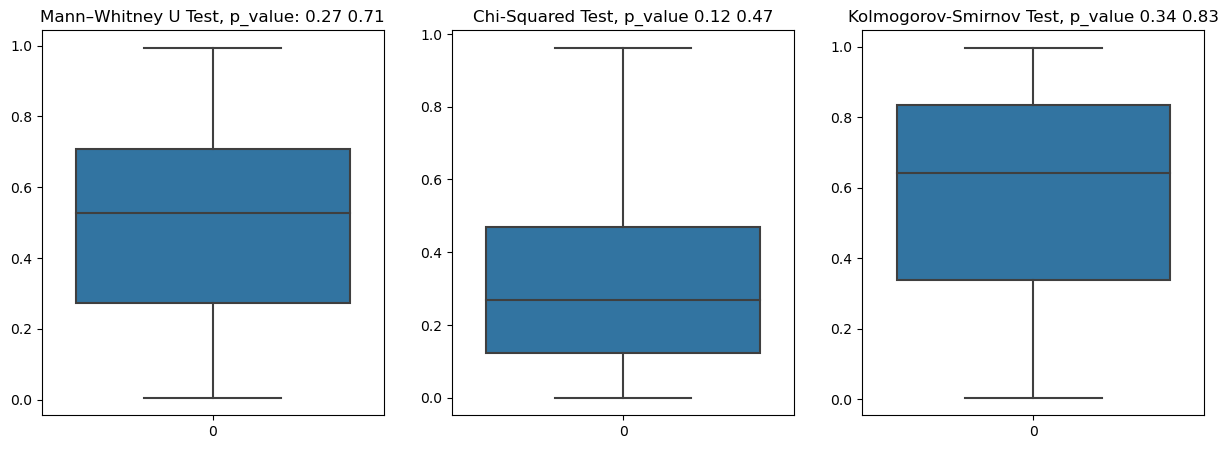

In [7]:
test_res = []
N = 100

for i in trange(N):
    test_res.append(test(data_df[4]['Coefficient'], RTP=0.96))


display_results(test_res)

## AA test

Mann–Whitney U Test: statistic=50031071.5000, p-value=0.9393
Chi-squared Test: statistic=6.0290, p-value=0.4200
Kolmogorov-Smirnov Test: statistic=0.0065, p-value=0.9841


(0.9393304974588756, 0.4199528853141544, 0.9841448923336962)

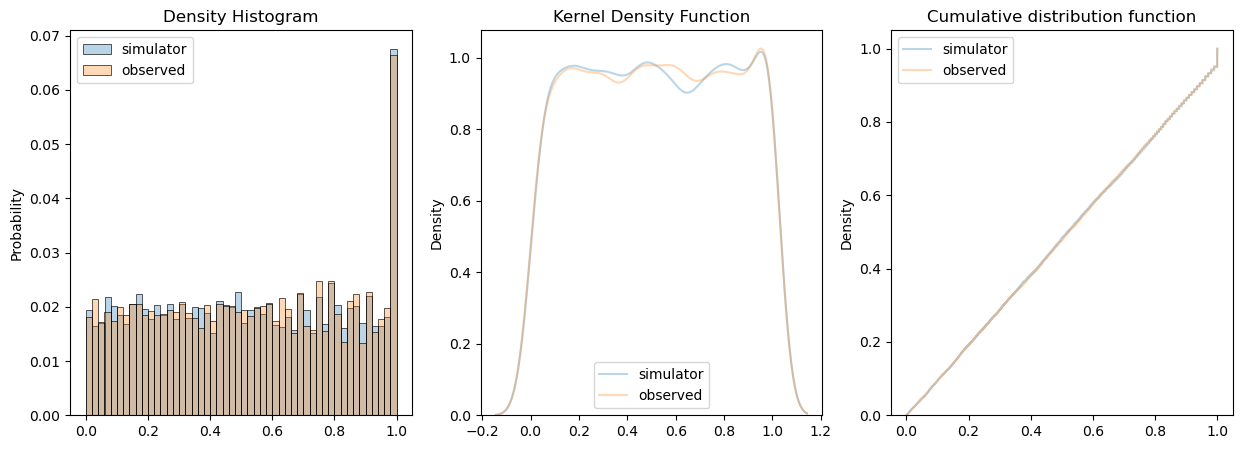

In [18]:
sim_A = generate_sim(10000, RTP=0.96)
test(sim_A, RTP=0.96, display=True, verbose=True)

100%|██████████| 100/100 [00:04<00:00, 24.61it/s]


,0.25,0.75
Mann–Whitney U Test,0.345362,0.755933
Chi-Squared Test,0.127428,0.643547
Kolmogorov-Smirnov Test,0.522888,0.900204


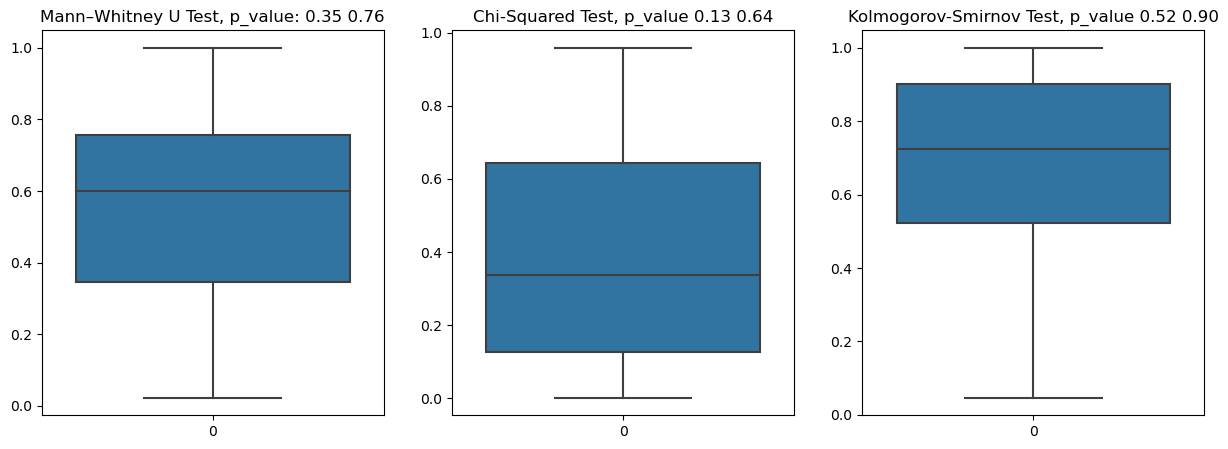

In [19]:
test_res = []
N = 100

for i in trange(N):
    test_res.append(test(sim_A, RTP=0.96))

display_results(test_res)

## Avaitor all files merged

Mann–Whitney U Test: statistic=226040321.5000, p-value=0.5998
Chi-squared Test: statistic=4.3360, p-value=0.6313
Kolmogorov-Smirnov Test: statistic=0.0071, p-value=0.6616


(0.5997839843741588, 0.6313058922623696, 0.6616286895602256)

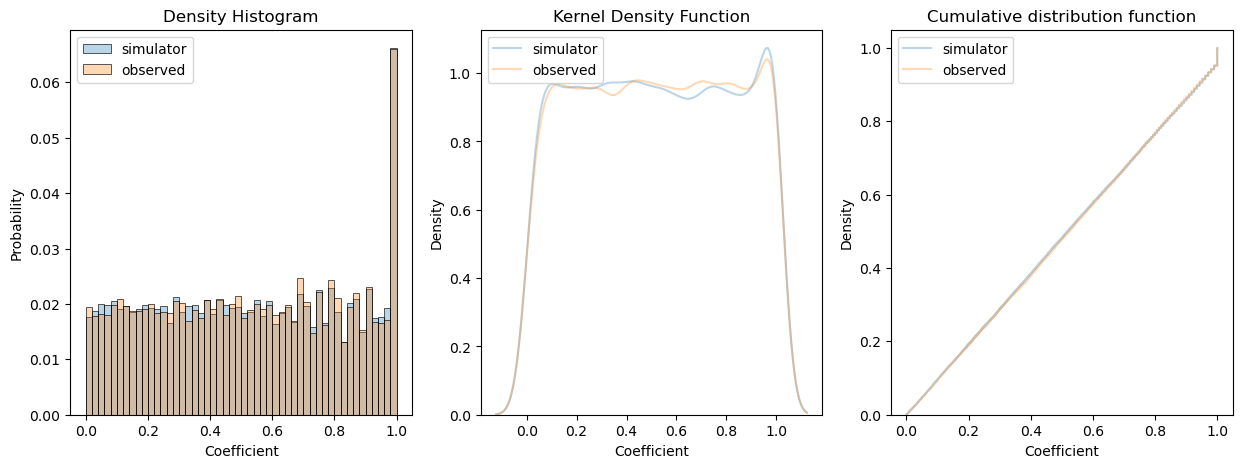

In [10]:
observ_all = pd.DataFrame()

for i in range(len(data_df)):
    observ_all = pd.concat([data_df[i], observ_all])

test(observ_all['Coefficient'], RTP=0.96, display=True, verbose=True)

100%|██████████| 100/100 [00:07<00:00, 13.65it/s]


,0.25,0.75
Mann–Whitney U Test,0.382666,0.783951
Chi-Squared Test,0.236057,0.717094
Kolmogorov-Smirnov Test,0.315294,0.790925


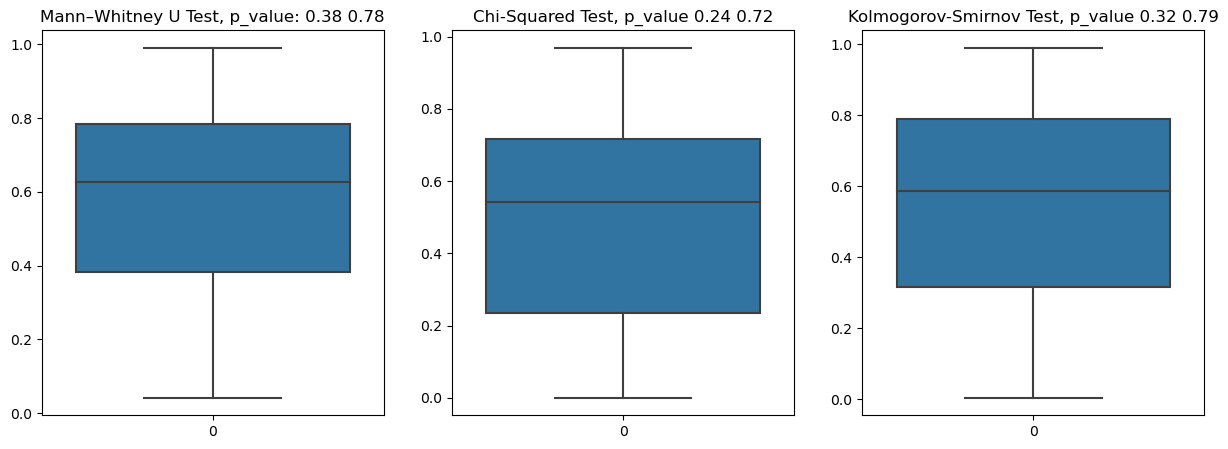

In [11]:
test_res = []
N = 100

for i in trange(N):
    test_res.append(test(observ_all['Coefficient'], RTP=0.96))

display_results(test_res)

# Crash

In [22]:
data_df = []

for root, dirs, files in os.walk("./crash/"):
    for n, f in enumerate(files):
        if "txt" in f:
            df = pd.read_csv("./crash/" + f, header=None)
            df['file'] = f
            data_df.append(df)

In [23]:
RTP_res = []
for  i in range(len(data_df)):
    b = 1.01 # floor
# b = 1.005 # round

    a = (data_df[i][0] == 1).mean()
    RTP = b * (1 - a)
    RTP_res.append(RTP)

RTP_res

[0.967316592, 0.9800413800000001]

## Chasher 96.5

Mann–Whitney U Test: statistic=200021414.0000, p-value=0.9852
Chi-squared Test: statistic=6.4907, p-value=0.3705
Kolmogorov-Smirnov Test: statistic=0.0077, p-value=0.5909


(0.9852038306833428, 0.370518777922761, 0.5908602093244772)

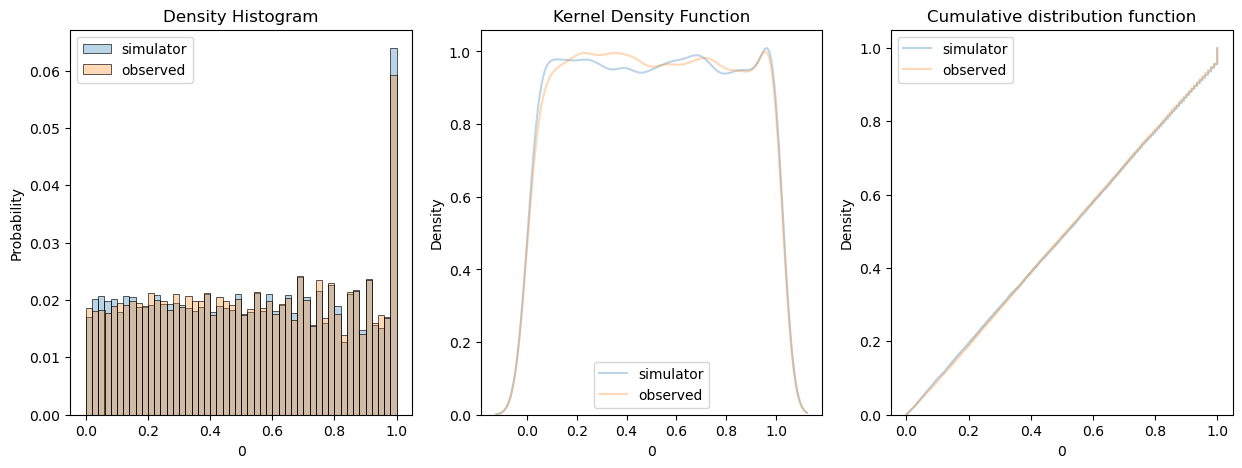

In [24]:
test(data_df[0].sample(n=20000)[0], RTP=0.965, display=True, verbose=True)

100%|██████████| 100/100 [01:21<00:00,  1.22it/s]


,0.25,0.75
Mann–Whitney U Test,0.215516,0.780917
Chi-Squared Test,0.006875,0.228765
Kolmogorov-Smirnov Test,0.236380,0.759756


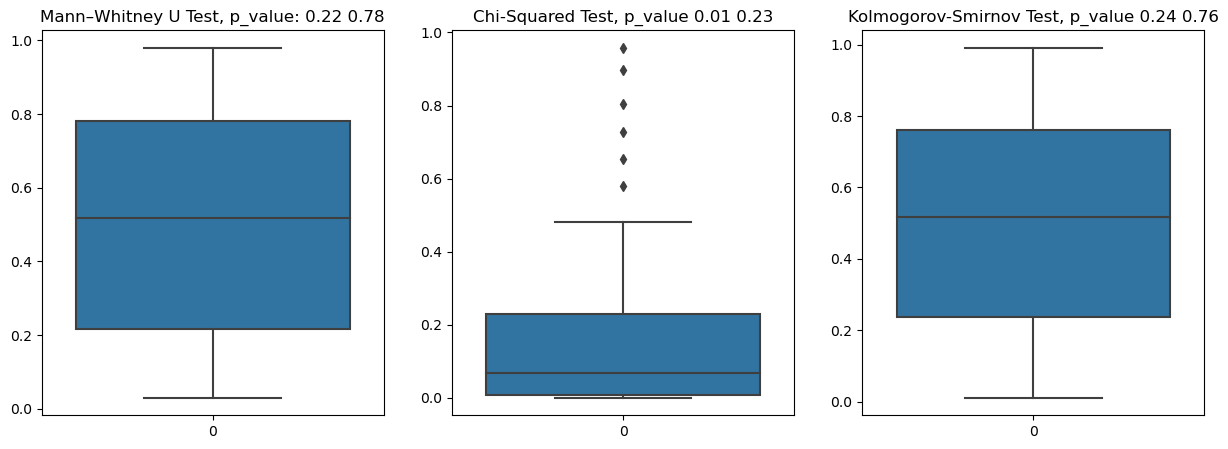

In [25]:
test_res = []
N = 100

for i in trange(N):
    test_res.append(test(data_df[0].sample(n=20000)[0], RTP=0.965))

display_results(test_res)

## Carsher 98

Mann–Whitney U Test: statistic=201142268.5000, p-value=0.3225
Chi-squared Test: statistic=6.5156, p-value=0.3680
Kolmogorov-Smirnov Test: statistic=0.0088, p-value=0.4185


(0.3225445653236858, 0.36796758005616764, 0.418541679034626)

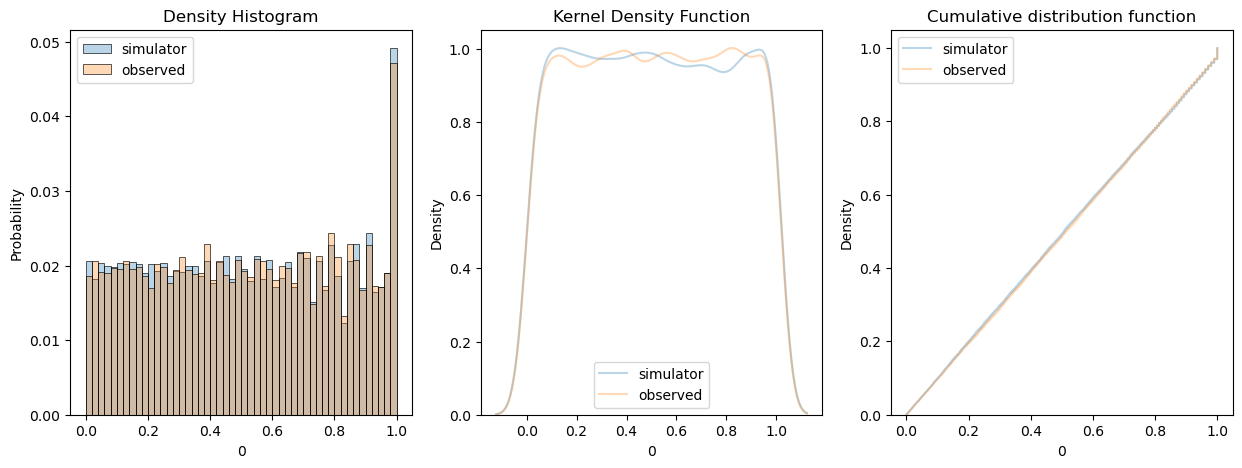

In [16]:
test(data_df[1].sample(n=20000)[0], RTP=0.98, display=True, verbose=True)

100%|██████████| 100/100 [00:12<00:00,  7.93it/s]


,0.25,0.75
Mann–Whitney U Test,0.238595,0.746206
Chi-Squared Test,0.038300,0.610640
Kolmogorov-Smirnov Test,0.223403,0.791374


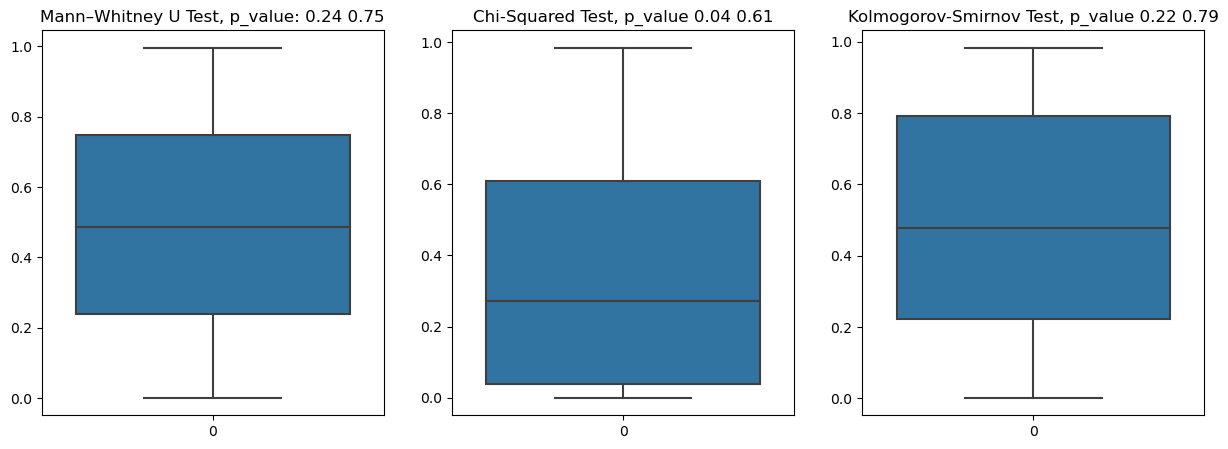

In [17]:
test_res = []
N = 100

for i in trange(N):
    test_res.append(test(data_df[1].sample(n=20000)[0], RTP=0.98))

display_results(test_res)